# Poisson's Equation in 2D

Here we explore numerical solutions to Poisson's equation in 2D

\begin{align}
  \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} 
  = s
\end{align}

where $u=u(x,y)$ and $s=s(x,y)$. Note that Laplace's equation is simply the homogenous version of this equation. As before, we take the boundary to be a 2D rectangular grid with dimensions $L_x$ and $L_y$. 

And once again we may use Dirichlet boundary conditions

\begin{align}
  u(0, y) = f_{1}(y) 
  \quad,\quad u(L_{x}, y) = f_{2}(y)
  \quad,\quad u(x, 0) = f_{3}(x) 
  \quad,\quad u(x, L_{y}) = f_{4}(x),
\end{align}

or Neumann boundary conditions

\begin{align}
  \frac{\partial u}{\partial x}(0, y) = g_{1}(y) 
  \quad,\quad \frac{\partial u}{\partial x}(L_{x}, y) = g_{2}(y) 
  \quad,\quad \frac{\partial u}{\partial y}(x, 0) = g_{3}(x) 
  \quad,\quad \frac{\partial u}{\partial y}(x, L_{y}) = g_{4}(y),
\end{align}

or some combination (Robin, or mixed, boundary conditions).

As with Laplace's equation, we discretize the spatial derivatives using centered finite differences. After re-arranging, this yields the relaxation equation

\begin{align}
  u^{[n+1]}_{i,j} =
  \frac{(\Delta{y})^2\left(u^{[n]}_{i+1,j} + u^{[n]}_{i-1,j}\right)
  + (\Delta{x})^2\left(u^{[n]}_{i,j+1} + u^{[n]}_{i,j-1}\right)
  - (\Delta{x})^2(\Delta{y})^2 s_{i,j}}{2\left((\Delta{x})^2 + (\Delta{y})^2\right)}.
\end{align}

If we use a uniform grid with $h \equiv \Delta{x} = \Delta{y}$, this simplifies to

\begin{align}
  u^{[n+1]}_{i,j} =
  \frac{1}{4}\left(u^{[n]}_{i+1,j} + u^{[n]}_{i-1,j} 
  + u^{[n]}_{i,j+1} + u^{[n]}_{i,j-1}\right)
  - \frac{h^2}{4}s_{i,j}.
\end{align}

This yields Jacobi's method for solving Poisson's equation.

In [1]:
import numpy as np
import time
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

In [2]:
# Jacobi iterator
def jacobi(dx, dy, sf, uold):
    """
    This applies one iteration of the Jacobi method to solve for interior points throughout 
    a rectangular 2D grid, based on a previous solution.
    
    INPUT:
    dx = grid spacing in the x direction
    dy = grid spacing inthe y direction
    sf = source grid function
    uold = previous solution of the grid function u
    
    OUTPUT:
    unew = updated grid function u
    """
    unew = np.copy(uold)
    unew[1:-1, 1:-1] \
    = 0.5*dx*dx/(dx*dx + dy*dy)*(uold[1:-1, 2:  ] + uold[1:-1, 0:-2]) \
    + 0.5*dy*dy/(dx*dx + dy*dy)*(uold[2:  , 1:-1] + uold[0:-2, 1:-1]) \
    - 0.5*dx*dx*dy*dy/(dx*dx + dy*dy)*sf[1:-1, 1:-1]
    return unew

In [3]:
# relative error
from numpy import linalg as la
def relerr(unew, uold, order):
    """
    Calculate relative error from one iteration to the next, based on a specified
    order matrix norm. (For Euclidean, or L2-norm, use order = 2)
    
    INPUT:
    unew = grid function at current iteration
    uold = grid function at previous iteration
    order = order of matrix norms to use in the calculation
    
    OUTPUT:
    relative error
    """
    return la.norm(unew - uold, order)/la.norm(unew, order)

In [4]:
# plot function
def uplot(iterStep, iterErr, X, Y, U, zmax, axis, fig):
    axis.cla()                   #clear previous plot
    axis.set_zlim(0, zmax) #set z limits of plot
    axis.set_xlabel('x')         #set x-axis label
    axis.set_ylabel('y')         #set y-axis label
    axis.set_zlabel('u(x,y,t)')  #set z-axis label
    axis.set_title('iteration %.2f, estimated relative error %f' % (iterStep, iterErr)) #set title 
    axis.plot_surface(X, Y, U, rstride=2, cstride=2, cmap='viridis') #plot u vs x,y
    fig.canvas.draw()            #redraw figure
    time.sleep(0.05)             #pause

In [5]:
# function to solve Poisson's equation in 2D    
def poisson2D(Lx, Ly, nx, ny, iterator, tol, maxiter):
    """
    this solves Poisson's equation in 2D
    
    Lx = size of spatial grid in the x direction
    Ly = size of spatial grid in the y direction
    nx = total number of spatial grid points in the x direction
    ny = total number of spatial grid points in the y direction
    iterator = handle of function used to iterate solutions
    tol = target tolerance
    maxiter = max number of iterations, in case tolerance is never reached
    """
    # setup spatial grid (vertex-centered)
    dx = Lx/(nx-1)   # grid spacing in x direction
    dy = Ly/(ny-1)   # grid spacing in y direction
    x = np.linspace(0, Lx, nx) # x grid
    y = np.linspace(0, Ly, ny) # y grid
    X, Y = np.meshgrid(x, y, indexing='ij')
    #print('x grid spacing is',dx)
    #print('y grid spacing is',dy)

    # Dirichlet boundary conditions
    f1 = 0.*np.ones(nx)
    f2 = 0.*np.ones(nx)
    f3 = 0.*np.ones(ny)
    f4 = 0.*np.ones(ny)
    
    # Neumann boundary conditions
    g1 = 0.*np.ones(nx)
    g2 = 0.*np.ones(nx)
    g3 = 0.*np.ones(ny)
    g4 = 0.*np.ones(ny)

    # initialize grid functions
    s = np.zeros((nx,ny))  # source grid function
    u = np.zeros((nx,ny))  # solution grid function at the current step
    un = np.zeros((nx,ny)) # solution grid function at the previous step

    # source function
    s[int(ny/4), int(nx/4)]  = 100
    s[int(3*ny/4), int(3*nx/4)] = -100
    
    # initial solution configuration
#    A = 2.
#    kx = 2*np.pi/Lx
#    ky = 18*np.pi/Ly
#    u = A*np.sin(kx*X)*np.sin(ky*Y) #u at interior points
    u[ 0, 1:-1] = f1[1:-1]  #u at x=0, 0<y<Ly
    u[-1, 1:-1] = f2[1:-1]  #u at x=Lx, 0<y<Ly
    u[1:-1,  0] = f3[1:-1]  #u at y=0, 0<x<Lx
    u[1:-1, -1] = f4[1:-1]  #u at y=Ly, 0<x<Lx
    umax0 = 0.001*np.amax(s)   #max value (for plotting)
    
    # create figure
    fig = plt.figure(figsize=(7, 5), dpi=100)
    ax1 = fig.gca(projection='3d')

    # solve
    for n in range(maxiter):
        # copy solution from previous time step
        un = u.copy()

        # update solution at interior points
        u = iterator(dx, dy, s, un)

        # update solution at boundary points
        # uncomment this block to use Dirichlet boundary conditions
        u[ 0, 1:-1] = f1[1:-1]  #u at x=0, 0<y<Ly
        u[-1, 1:-1] = f2[1:-1]  #u at x=Lx, 0<y<Ly
        u[1:-1,  0] = f3[1:-1]  #u at y=0, 0<x<Lx
        u[1:-1, -1] = f4[1:-1]  #u at y=Ly, 0<x<Lx
        u[ 0,  0] = 0.5*(f1[ 0] + f3[ 0])  #u at x=0, y=0
        u[-1,  0] = 0.5*(f2[ 0] + f3[-1])  #u at x=Lx, y=0
        u[ 0, -1] = 0.5*(f1[-1] + f4[ 0])  #u at x=0, y=Ly 
        u[-1, -1] = 0.5*(f2[-1] + f4[-1])  #u at x=Lx, y=Ly
        # uncomment this block to use Neumann boundary conditions
#        cx = dx*dx/(dx*dx + dy*dy)
#        cy = dy*dy/(dx*dx + dy*dy)
#        u[ 0, 1:-1] = 0.5*cx*(u[ 0, 2:] + u[ 0, 0:-2]) + cy*(u[ 1, 1:-1] - dx*g1[1:-1]) #du/dx at x=0, 0<y<Ly
#        u[-1, 1:-1] = 0.5*cx*(u[-1, 2:] + u[-1, 0:-2]) + cy*(u[-2, 1:-1] + dx*g2[1:-1]) #du/dx at x=Lx, 0<y<Ly
#        u[1:-1,  0] = cx*(u[1:-1,  1] - dy*g3[1:-1]) + 0.5*cy*(u[2:,  0] + u[0:-2,  0]) #du/dx at y=0, 0<x<Lx
#        u[1:-1, -1] = cx*(u[1:-1, -2] + dy*g4[1:-1]) + 0.5*cy*(u[2:, -1] + u[0:-2, -1]) #du/dx at y=Ly, 0<x<Lx
#        u[ 0,  0] = cx*(u[ 0,  1] - dy*g3[ 0]) + cy*(u[ 1,  0] - dx*g1[ 0])  #du/dx at x=0, y=0
#        u[ 0, -1] = cx*(u[ 0, -2] + dy*g4[ 0]) + cy*(u[ 1, -1] - dx*g1[-1])  #du/dx at x=0, y=Ly
#        u[-1,  0] = cx*(u[-1,  1] - dy*g3[-1]) + cy*(u[-2,  0] + dx*g2[ 0])  #du/dx at x=Lx, y=0
#        u[-1, -1] = cx*(u[-1, -2] + dy*g4[-1]) + cy*(u[-2, -1] + dx*g2[-1])  #du/dx at x=Lx, y=Ly
                    
        # calculate and check relative error
        err = relerr(u, un, 2)
        if err <= tol:
            break

        #plot configuration
        uplot(n, err, X, Y, u, 1.15*umax0, ax1, fig)

<IPython.core.display.Javascript object>


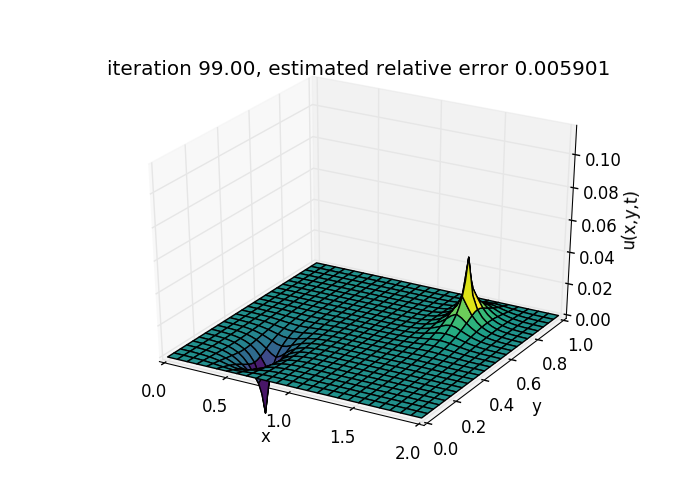

In [6]:
poisson2D(2., 1., 51, 51, jacobi, 1e-3, 100)

## Gauss-Seidel

The Gauss-Seidel iteration equation becomes

\begin{align}
  u^{[n+1]}_{i,j} =
  \frac{1}{4}\left(u^{[n+1]}_{i-1,j} + u^{[n+1]}_{i,j-1}
  + u^{[n]}_{i+1,j} + u^{[n]}_{i,j+1}\right)
  - \frac{h^2}{4} s_{i,j}.
\end{align}

In [7]:
# Gauss-Seidel iterator
def gauss_seidel(dx, dy, sf, uold):
    """
    This applies one iteration of the Gauss-Seidel method to solve for interior points throughout 
    a rectangular 2D grid, based on a previous solution.
    
    INPUT:
    dx = grid spacing in the x direction
    dy = grid spacing inthe y direction
    sf = source grid function
    uold = previous solution of the grid function u
    
    OUTPUT:
    unew = updated grid function u
    """
    unew = np.copy(uold)
    nx = len(uold[:,0])
    ny = len(uold[0,:])
    for i in range(1,nx-1):
        for j in range (1,ny-1):
            unew[i, j] \
            = 0.5*dx*dx/(dx*dx + dy*dy)*(uold[i, j+1] + unew[i, j-1]) \
            + 0.5*dy*dy/(dx*dx + dy*dy)*(uold[i+1, j] + unew[i-1, j]) \
            - 0.5*dx*dx*dy*dy/(dx*dx + dy*dy)*sf[i, j]
    return unew

<IPython.core.display.Javascript object>


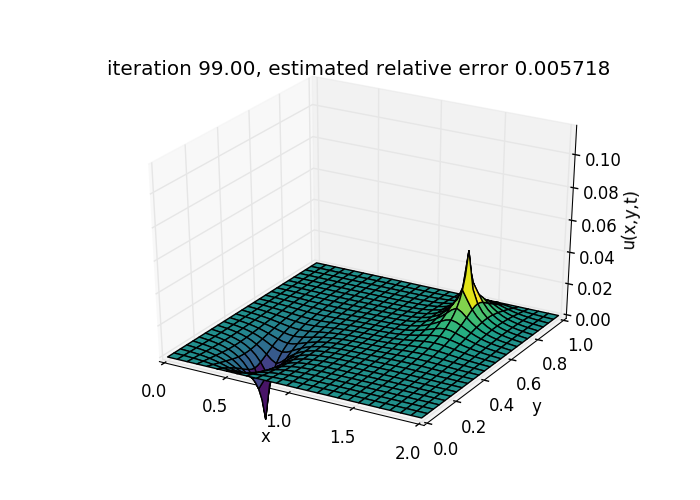

In [8]:
poisson2D(2., 1., 51, 51, gauss_seidel, 1e-3, 100)

## Successive Over-Relaxation

The SOR iteration equation becomes

\begin{align}
  u^{[n+1]}_{i,j} =
  (1 - \omega)u^{[n]}_{i,j}
  + \frac{\omega}{4}\left[\left(u^{[n+1]}_{i-1,j} + u^{[n+1]}_{i,j-1}
  + u^{[n]}_{i+1,j} + u^{[n]}_{i,j+1}\right)
  - h^2 s_{i,j}\right].
\end{align}

In [9]:
# SOR iterator
def sor(dx, dy, sf, uold):
    """
    This applies one iteration of the SOR method to solve for interior points throughout 
    a rectangular 2D grid, based on a previous solution.
    
    INPUT:
    dx = grid spacing in the x direction
    dy = grid spacing inthe y direction
    sf = source grid function
    uold = previous solution of the grid function u
    
    OUTPUT:
    unew = updated grid function u
    """
    omega = 1.95 #for stable over-relaxation: 1.0 < omega < 2.0
    unew = np.copy(uold)
    nx = len(uold[:,0])
    ny = len(uold[0,:])
    for i in range(1,nx-1):
        for j in range (1,ny-1):
            unew[i, j] \
            = (1 - omega)*uold[i, j] \
            + omega*0.5*dx*dx/(dx*dx + dy*dy)*(uold[i, j+1] + unew[i, j-1]) \
            + omega*0.5*dy*dy/(dx*dx + dy*dy)*(uold[i+1, j] + unew[i-1, j]) \
            - omega*0.5*dx*dx*dy*dy/(dx*dx + dy*dy)*sf[i, j]
    return unew

<IPython.core.display.Javascript object>


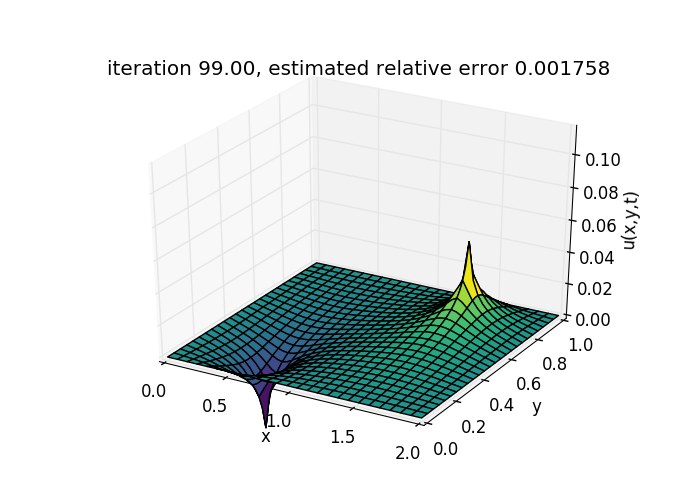

In [10]:
poisson2D(2., 1., 51, 51, sor, 1e-3, 100)